# Implicit shape interpolation.

In this lab work we will focus on interpolating between shapes $\mathcal{S}_0$ and $\mathcal{S}_1$. We will make so using the Level Set Equation (see e.g. <a href="https://ieeexplore.ieee.org/abstract/document/938899">link</a>).
We now parameterize not only a single shape, but the whole path $F_\theta(x, t)$ between two shapes, i.e. $F_{\theta}(x, 0)$ is the SDF of the first shape $\mathcal{S}_0$ and $F_\theta(x, 1)$ is the SDF of the second shape $\mathcal{S}_1$

Given a temporal signed distance function $F_\theta(x, t)$, the level set equation encodes the motion of the level set following a prescribed vector field $V$ :
$$
\frac{\partial F(x, t)}{dt} + \langle \nabla F, V \rangle = 0
$$
with $F(x, 0)$ set to be the signed distance field of the initial shape $\mathcal{S}_0$.
It has been used with neural signed distance functions only in 2023 (<a href="https://openaccess.thecvf.com/content/ICCV2023/papers/Novello_Neural_Implicit_Surface_Evolution_ICCV_2023_paper.pdf"> link </a>). This lab will focus on replicating the code of the paper.

In [1]:
!wget https://www.lix.polytechnique.fr/~pierson/cours/TP6.zip

In [2]:
!unzip -o TP6.zip
!ls

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

## SIREN Neural network

The networks are built with <a href="https://arxiv.org/pdf/2006.09661">SIREN</a>. The network activation are sinusoidal functions, and a Siren layer is a network of the form
$$
\phi(x) = \sin(\omega_0*(W x + b))
$$

with $\omega_0 = 30$.

The network is initialized such that the first layer weight follow a $\mathcal{U}([-1/d_{in}, 1/d_{in}])$ (bias are initialized same), with $d_{in}$ the input feature, and the other follow a law $\mathcal{U}([-\frac{\sqrt{6/d_{in}}}{\omega_0}, \frac{\sqrt{6/d_{in}}}{\omega_0}])$.

In [4]:
class SirenLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.bias = bias
        
        self.in_features = in_features
        self.lin = nn.Linear(in_features, out_features, bias=bias)
        
        self._init_weights()

    def _init_weights(self):
        bound = 1 / self.in_features if self.is_first else torch.sqrt(torch.tensor(6 / self.in_features)) / self.omega_0
        with torch.no_grad():
            nn.init.uniform_(self.lin.weight, -bound, bound)
            if self.bias:
                nn.init.uniform_(self.lin.bias, -bound, bound)

    def forward(self, x):
        x = self.lin(x)
        x = torch.sin(self.omega_0 * x)
        return x

### Neural network logic
A siren network is of the form :
$$
\Phi(x) = W * (\phi_0  \circ \phi_1 \circ \phi_2 ....)(x) + b
$$

Build the network. The SIREN layers have constant output dimension hidden_dim. Optionnally, you can have skip connections on certain layers (you can ignore it for the beginning). Note that here, $x$ is in reality $x, t$ where $x$ is the coordinates in space and $t$ the coordinates in time.

In [5]:
class SirenNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.skip = [i for i in range(1, num_layers)] if len(skip)==0 else skip
        self.omega_0 = omega_0

        layers = [
            SirenLayer(dim_in, dim_hidden, omega_0=omega_0, is_first=True)
        ] + [
            SirenLayer(dim_hidden, dim_hidden, omega_0=omega_0) for _ in range(1, num_layers)
        ]
        
        # Initialize last layer
        self.last_lin = nn.Linear(dim_hidden, dim_out)
        self._init_last_layer_weights()

        self.layers = nn.ModuleList(layers)

    def _init_last_layer_weights(self):
        bound = torch.sqrt(torch.tensor(6 / self.dim_hidden)) / self.omega_0
        with torch.no_grad():
            nn.init.uniform_(self.last_lin.weight, -bound, bound)
            nn.init.uniform_(self.last_lin.bias, -bound, bound)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            f_x = layer(x)
            x = x + f_x if i in self.skip else f_x

        x = self.last_lin(x)
        return x

# Loss functions

A few loss functions are required to make the network work properly.

### Shape data attachement loss
The data attachement loss contains two terms. First the network should be $0$ on the shape:

$$
\mathcal{L}_{data} = \sum_{x \in \mathcal{S}_0} ||F_\theta(x, 0)||^2
$$

Second, the gradient of the SDF should be equal to the normal on the surface:

$$
\mathcal{L}_{normal} = \sum_{(x,n) \in \mathcal{S}_0} ||1 - \langle n, \nabla_\theta F_\theta(x, 0)||^2
$$

Write the code for $\mathcal{L}_{data}$

In [6]:
def loss_data(sdf_pc):
    """
    sdf_pc (batch_size, 1)
    """
    loss = (sdf_pc**2).sum()
    return loss

The computation of the gradient will be given. Write the code for $\mathcal{L}_{normal}$

In [7]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def loss_normalign(grad_pc, sample_nc):
    """
    grad_pc: (batch_size, 2) gradient vector at each point of the sample point cloud
    sample_nc: (batch_size, 2) normal vector at each point of the sample point cloud
    """
    dot_prod = torch.sum(grad_pc * sample_nc, dim=1) # (batch_size,)
    loss = torch.linalg.norm(1 - dot_prod)**2 
    return loss 

Now, given pc, normals as input, and a batch_size, sample batch size points and return $100*\mathcal{L}_{data} + \mathcal{L}_{normal}$

In [8]:
def loss_shape_data(net, pc, normals, batch_size=2000, dim_space=2, end=False):
    #sample batch size points and the corresponding normals
    indices = torch.randperm(pc.shape[0])[:batch_size] # (batch_size,)
    sample_pc = pc[indices] # (batch_size, 3)
    sample_pc[:,-1] = 0 if not end else 1 # (x,0)
    sample_pc.requires_grad = True
    sample_pc = sample_pc.to(device)
    
    sample_nc = normals[indices] # (batch_size, 2)

    sdf_pc = net(sample_pc).squeeze() # F(x,0) (batch_size,)
    #spatial gradients
    grad_pc = gradient(sdf_pc, sample_pc)[:,:dim_space] # (batch_size,) x (batch_size, 2) -> (batch_size, 2)

    ## compute loss
    loss_pc = 100 * loss_data(sdf_pc) + loss_normalign(grad_pc, sample_nc)
    return loss_pc

### SDF data attachement loss
Like in deepSDF, we learn the SDF based on the ground truth SDF in ambient space (we suppose we have a way to compute it).

The loss is given as
$$
\begin{align} \mathcal{L}_{amb} &=  \mathbb{E}_{x \sim X} [\|F_\theta(x, 0) - \text{SDF}_{\text{gt}}(x)\|²] \\ 
\end{align}
$$
where $X$ is the ambient space.

In practice, we have already sampled points before as in previous lab. Code the loss function that randomly selects them and compute the loss. Return $10*\mathcal{L}_{amb}$

In [9]:
def loss_amb(net, pc_hint, gt_sdf, batch_size=2000, end=False):
    """
    net: neural net
    pc_hint: (N,3) x + time
    gt_sdf: (N,)
    """ 
    indices = torch.randperm(pc_hint.shape[0])[:batch_size] # (batch_size)
    sample_pc = pc_hint[indices] # (batch_size, 3)
    sample_pc[:,-1] = 0 if not end else 1 # (x,0)
    sample_pc = sample_pc.to(device)
    sample_sdf = net(sample_pc).squeeze() # F(x, 0) -> (batch_size,)
    loss = torch.linalg.norm(sample_sdf - gt_sdf[indices])**2
    return 10 * loss

### Eikonal loss

The final loss is based on the fact that the SDF respects the eikonal equation (the gradient of the SDF is always one):
$$
||\nabla_x \text{SDF}_x || = 1
$$
The loss is given by:
$$
\mathbb{E}_{x, t} \left[\|1-\|\nabla_x F_\theta (x, t)\|\|\right]
$$
This expectation is approximated using a Monte Carlo estimation, at each step, points and time steps are sampled in the ambient space and we evaluate the sum at these points.

In [10]:
def loss_eikonal_pts(grad_pts):
    # grad_pts (batch_size, 2)
    loss = torch.linalg.norm(1 - torch.norm(grad_pts, dim=1))**2
    return loss 

def loss_eikonal(net, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute eikonal loss
    pts_random = torch.rand(batch_size, 3) # (batch_size, 3)
    pts_random[:,:-1] = 2 * pts_random[:,:-1] - 1
    pts_random.requires_grad = True
    pts_random = pts_random.to(device) 

    sdf_random = net(pts_random).squeeze() # (batch_size, 1)

    grad_tot_random = gradient(sdf_random, pts_random) # (batch_size, 3)
    grad_spatial = grad_tot_random[:,:2] # (batch_size, 2)
    return loss_eikonal_pts(grad_spatial)

### Levet set loss

In the case of a constant vector field, the equation reads as:

$$
\mathcal{L}_{lse} = \mathbb{E}_{(x, t)} [|| \frac{\partial F_\theta(x, t)}{\partial t} + \langle \nabla F_\theta(x, t), V \rangle||^2]
$$

This expectation is approximated using a Monte Carlo estimation, at each step, points and time steps are sampled in the ambient space and we evaluate the sum at these points.

In [11]:
def loss_lse_eq(net, vf, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute lse loss
    pts_random = torch.rand(batch_size, dim_space + 1, device=device)
    pts_random[:,:dim_space] = 2 * pts_random[:,:dim_space] - 1 # scaling in [-1, 1] 
    pts_random.requires_grad = True
    
    sdf_random = net(pts_random).squeeze() # (batch_size, 1)

    grad_tot_random = gradient(sdf_random, pts_random) # (batch_size, 3)
    #spatal gradient
    grad_random = grad_tot_random[:,:dim_space] # (batch_size, 2)

    #temporal gradient
    tempgrad_random = grad_tot_random[:,dim_space] # (batch_size, 1)

    dot_prod = torch.sum(grad_random * vf, dim=1) # (batch_size,1)
    
    ## compute the loss
    loss_lse = torch.linalg.norm(tempgrad_random + dot_prod)**2
    return loss_lse

In [12]:
def evaluate_loss_cst_vf(net, pc, normals, hints_pc, gtsdf, vf,
                           lpc, leik, lh, llse,
                           lambda_pc = 1, lambda_eik = 2, lambda_hint = 1, lambda_lse = 1, batch_size = 2000):



    # compute and store standard losses
    loss_pc = loss_shape_data(net, pc, normals, batch_size)

    loss_hint = loss_amb(net, hints_pc, gtsdf, batch_size)

    loss_eik = loss_eikonal(net, batch_size)

    loss_lse = loss_lse_eq(net, vf, batch_size)

    # append all the losses
    lpc.append(float(loss_pc))
    leik.append(float(loss_eik))
    lh.append(float(loss_hint))
    llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    loss = lambda_pc*loss_pc + lambda_eik*loss_eik + lambda_hint*loss_hint + lambda_lse*loss_lse

    return loss

In [13]:
def optimize_nise_vf(net, pc0, nc0, hints0, gtsdf0, vf, lpc, leik, lh, llse, lambda_pc = 1, lambda_eik = 2, lambda_hint = 1, lambda_lse = 2, batch_size = 2000, nepochs=100, plot_loss = True):

    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)

    tinit = time.time()
    pbar = tqdm(total=nepochs,
                desc="Training")
    for batch in range(nepochs):
        optim.zero_grad()

        loss = evaluate_loss_cst_vf(net, pc0, nc0, hints0, gtsdf0, vf, lpc, leik, lh, llse, lambda_pc, lambda_eik, lambda_hint, lambda_lse, batch_size)

        loss.backward()
        optim.step()
        if batch % 100 == 99 or batch == 0:
        #     print(f"Epoch {epoch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)   

    tend = time.time()

    print("Optimizing NN took", '{:.2f}'.format(tend-tinit),"s.")

### Data
We work for the moment on simple 2D canonical shapes for example a circle and a square, but feel free to test on your own shapes. You will need points sampled on the shape with their normals $(x_i, n_i)$ and point sampled in the ambient space with their groundtruth signed distances $(\text{hint}_j, \text{SDF}_{\text{GT}}(\text{hint}_j))$.

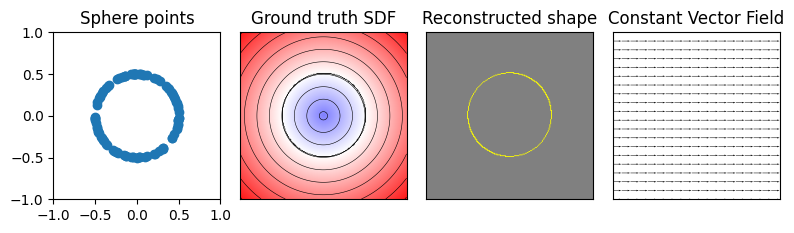

In [14]:
pc0,nc0,pts_hints0,gt_sdf_hints0,gt_grad_hints0, coords, sdf_coords = sphere_data(10000,100000)

#constant vector field (a single vector)
vf = torch.tensor([0.3,0.], device=device)


fig, axs =  plt.subplots(1, 4, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors='k', linewidths=.4, linestyles='solid')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")

def get_vector_field_meshgrid(X_value, Y_value):
    # Create a grid of points
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    X, Y = np.meshgrid(x, y)

    # Define the constant vector field (e.g., constant vector [1, 1] everywhere)
    U = np.ones_like(X)*X_value/(10*max(X_value, Y_value))  # constant x-component
    V = np.ones_like(Y)*Y_value/(10*max(X_value, Y_value))  # constant y-component
    return X,Y,U,V

X,Y,U,V = get_vector_field_meshgrid(vf[0].item(), vf[1].item())
axs[3].quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
axs[3].set_xlim((-1, 1))
axs[3].set_ylim((-1, 1))
axs[3].set_aspect("equal")
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title('Constant Vector Field')
axs[3].grid()
plt.tight_layout()
plt.show()

Check that the eikonal loss is correct

In [15]:
np.isclose(loss_eikonal_pts(gt_grad_hints0).item(), 0, atol=1e-6) ##Should be true

np.True_

Run the training and check the loss and results. We advice setting dim_hdden = 128, and a depth of 3 to start (faster). You can try improving the results later.

In [16]:
npl = 128
depth = 3
net = SirenNet(dim_in=3,dim_out=1,num_layers=depth,dim_hidden=npl,skip=[]).to(device)
lpc, leik, lh, llse = [], [], [], []

pc_t0 = torch.concat((pc0,torch.zeros((pc0.size(0),1), device = device)),dim=1)
pts_hintst0 = torch.concat((pts_hints0,torch.zeros((pts_hints0.size(0),1), device = device)),dim=1)


optimize_nise_vf(net, pc_t0, nc0, pts_hintst0, gt_sdf_hints0, vf, lpc, leik, lh, llse,nepochs=5000)

torch.save(net, "net_vf_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

/home/louis/mva/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Optimizing NN took 72.37 s.


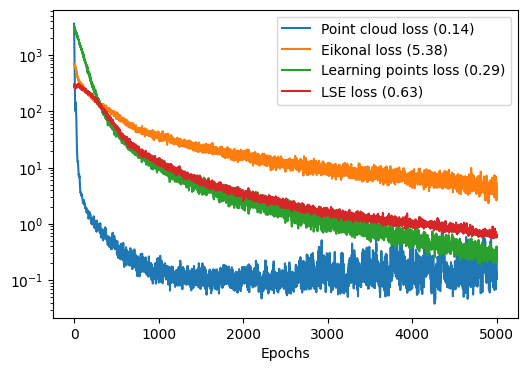

In [17]:
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(lpc, label = 'Point cloud loss ({:.2f})'.format(lpc[-1]))
plt.plot(leik, label = 'Eikonal loss ({:.2f})'.format(leik[-1]))
plt.plot(lh, label = 'Learning points loss ({:.2f})'.format(lh[-1]))
plt.plot(llse, label = 'LSE loss ({:.2f})'.format(llse[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results
We display the SDF and the resulting reconstructed shapes. You can find a potential example in the img/ folder

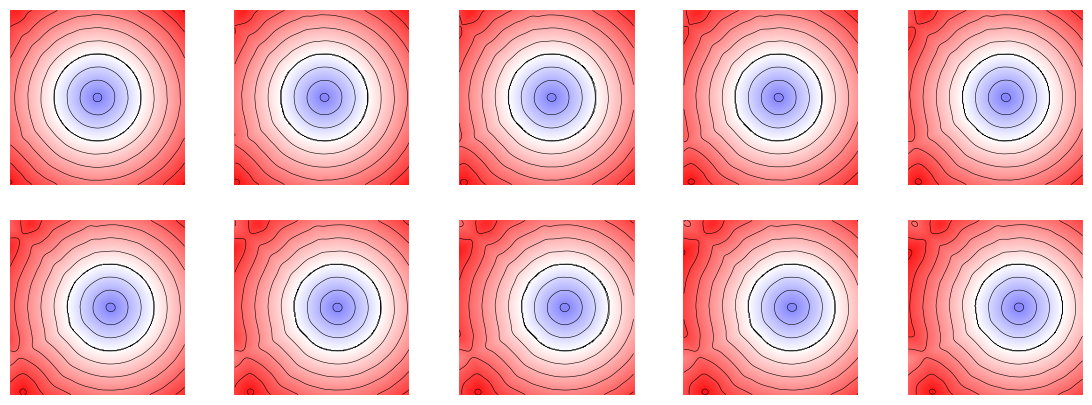

In [18]:
display_multi_slices(net, resolution=200,figsize=(14, 5))

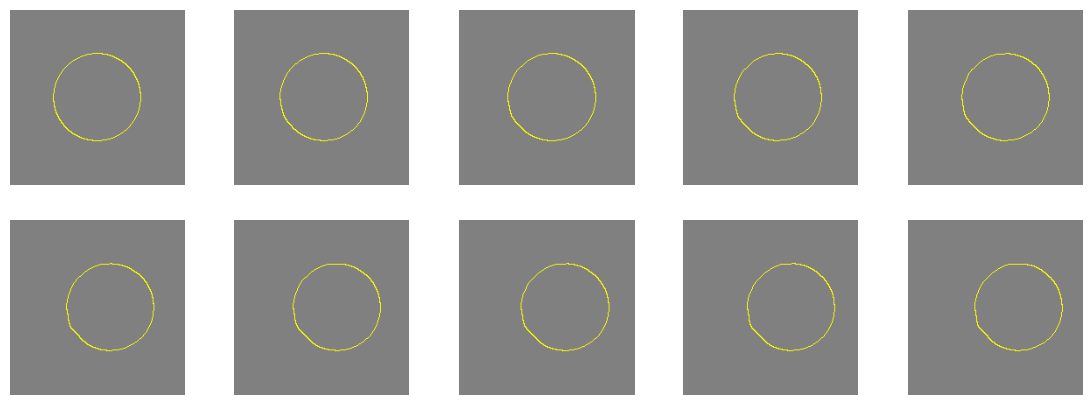

In [19]:
display_multiple_shapes_sdf(net, resolution=200, figsize=(14, 5))

## Morphing between shapes


The second test case consists into interpolate between two shapes, with signed distance functions $f_O$ at time 0 and $f_1$ at time 1. The vector field is not known in that case, but Novello et al. propose a simple and elegant solution, based on the following equality:
$$
V(x,t) = -(f_1(x) - F_{\theta}(x,t))\frac{\nabla F_{\theta}(x,t)}{\|\nabla F_{\theta}(x,t)\|}
$$
with
$$
F_{\theta}(x,0)=f_0(x)
$$

 Then by substitution in the LSE we have:
$$
\frac{\partial F_{\theta}(x,t)}{\partial t} - (f_1(x) - F_{\theta}(x,t))\|\nabla F_{\theta}(x,t)\| = 0
$$
and the loss:
$$
\mathcal L_{LSE}(\theta) = \mathbb{E}_{(x,t)}\Big[\Big\|\frac{\partial F_{\theta}(x,t)}{\partial t}- (f_1(x) - F_{\theta}(x,t))\|\nabla F_{\theta}(x,t)\|\Big\|^2\Big]
$$
Again the loss is evaluated using a Monte Carlo strategy

In [20]:
def loss_lse_morph(net, pc_hint, gt_sdf, batch_size):
    ## Sample batch size points with position hintspc, and add random time in [0, 1]
    indices = torch.randperm(pc_hint.shape[0])[:batch_size]
    random_hints = pc_hint[indices]
    times = torch.rand(batch_size) # (batch_size,)
    random_hints[:,-1] = times # (x,t)
    random_hints.requires_grad = True
    random_hints = random_hints.to(device)

    ## Evaluate SDF and gradient. Spatial gradient (nabla) is accessible via [:, 0:2], temporal derivative via [:, 2]
    sdf_random_hints = net(random_hints).squeeze() # F(x,t) (batch_size,)
    grad_tot_ = gradient(sdf_random_hints, random_hints) # (batch_size, 3)
    spatial_grad = grad_tot_[:,:2] # (batch_size, 2)
    #temporal gradient
    temp_deriv = grad_tot_[:,2] # (batch_size,)
    #compute the loss
    l_lse = torch.norm(temp_deriv - (gt_sdf[indices]-sdf_random_hints)*torch.linalg.norm(spatial_grad, dim=1))**2
    return l_lse

In [21]:
def evaluate_loss_morphing(net, pc0, normals0, hints_pc0, gtsdf0,
                           pc1, normals1, hints_pc1, gtsdf1,
                           lpc, leik, lh, llse,
                           lambda_pc = 100, lambda_eik = 2e2, lambda_hint = 1e2, lambda_lse = 1e2, batch_size = 2000):


    # compute and store standard losses
    loss_pc = loss_shape_data(net, pc0, normals0, batch_size) + loss_shape_data(net, pc1, normals1, batch_size, end=True)
    loss_hint = loss_amb(net, hints_pc0, gtsdf0, batch_size) + loss_amb(net, hints_pc1, gtsdf1, batch_size, end=True)

    loss_eik = loss_eikonal(net, batch_size)
    
    loss_lse = loss_lse_morph(net, hints_pc1, gtsdf1, batch_size)

    # append all the losses
    lpc.append(float(loss_pc))
    leik.append(float(loss_eik))
    lh.append(float(loss_hint))
    llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    loss = lambda_pc*loss_pc + lambda_eik*loss_eik + lambda_hint*loss_hint + lambda_lse*loss_lse

    return loss

### Interpolate between square and circle

In [22]:
#interpolate between a circle and a square
pc0,nc0,pts_hints0,gt_sdf_hints0,gt_grad_hints0,_,sdf_coords0 = sphere_data(10000,100000)
pc1,nc1,pts_hints1,gt_sdf_hints1,gt_grad_hints1,_,sdf_coords1 = square_data(10000,100000)

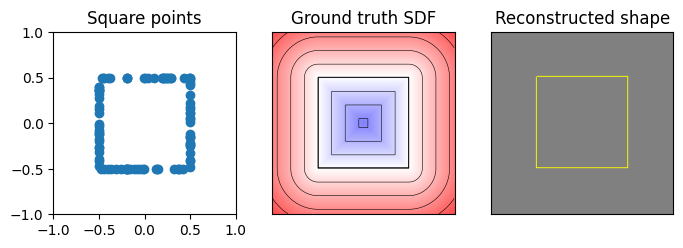

In [23]:
fig, axs =  plt.subplots(1, 3, figsize=(8, 10))
pc_numpy = pc1.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Square points")
sdf_numpy = sdf_coords1.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors='k', linewidths=.4, linestyles='solid')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")
a = 1

In [24]:
def optimize_nise_morphing(net, pc0, nc0, pc1, nc1, hints0, gtsdf0,
                           hints1, gtsdf1, lpc, leik, lh, llse,
                           lambda_pc = 1, lambda_eik = 2, lambda_hint = 1, lambda_lse = 2, batch_size = 2000, nepochs=100, plot_loss = True):

    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)
    #optim = torch.optim.LBFGS(params=net.parameters())
    tinit = time.time()
    pbar = tqdm(total=nepochs,
                desc="Training")
    for batch in range(nepochs):
        optim.zero_grad()

        loss = evaluate_loss_morphing(net, pc0, nc0, pc1, nc1, hints0, gtsdf0, hints1, gtsdf1, lpc, leik, lh, llse, lambda_pc, lambda_eik, lambda_hint, lambda_lse, batch_size)

        loss.backward()
        optim.step()

        if batch % 100 == 99 or batch == 0:
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)

    tend = time.time()

    print("Optimizing NN took", '{:.2f}'.format(tend-tinit),"s.")


In [25]:
npl = 128
depth = 3
net_morph = SirenNet(dim_in=3,dim_out=1,num_layers=depth,dim_hidden=npl,skip=[]).to(device)
lpc, leik, lh, llse = [], [], [], []



pc_t0 = torch.concat((pc0,torch.zeros((pc0.size(0),1), device = device)),dim=1)
pc_t1 = torch.concat((pc1,torch.ones((pc1.size(0),1), device = device)),dim=1) # zeros -> ones
pts_hintst0 = torch.concat((pts_hints0,torch.zeros((pts_hints0.size(0),1), device = device)),dim=1)
pts_hintst1 = torch.concat((pts_hints1,torch.ones((pts_hints1.size(0),1), device = device)),dim=1)

optimize_nise_morphing(net_morph, pc_t0, nc0, pts_hintst0, gt_sdf_hints0, pc_t1, nc1, pts_hintst1, gt_sdf_hints1, lpc, leik, lh, llse, nepochs=5000)

torch.save(net, "net_morph_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimizing NN took 121.26 s.


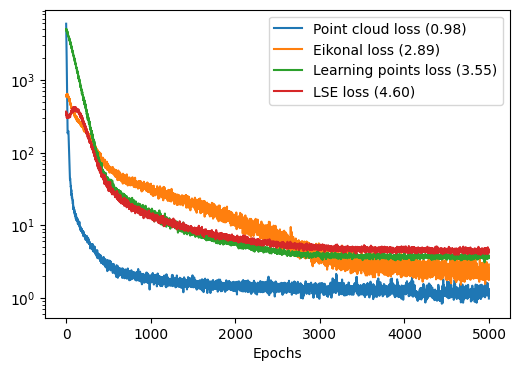

In [26]:
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(lpc, label = 'Point cloud loss ({:.2f})'.format(lpc[-1]))
plt.plot(leik, label = 'Eikonal loss ({:.2f})'.format(leik[-1]))
plt.plot(lh, label = 'Learning points loss ({:.2f})'.format(lh[-1]))
plt.plot(llse, label = 'LSE loss ({:.2f})'.format(llse[-1]))
plt.xlabel("Epochs")
plt.legend()

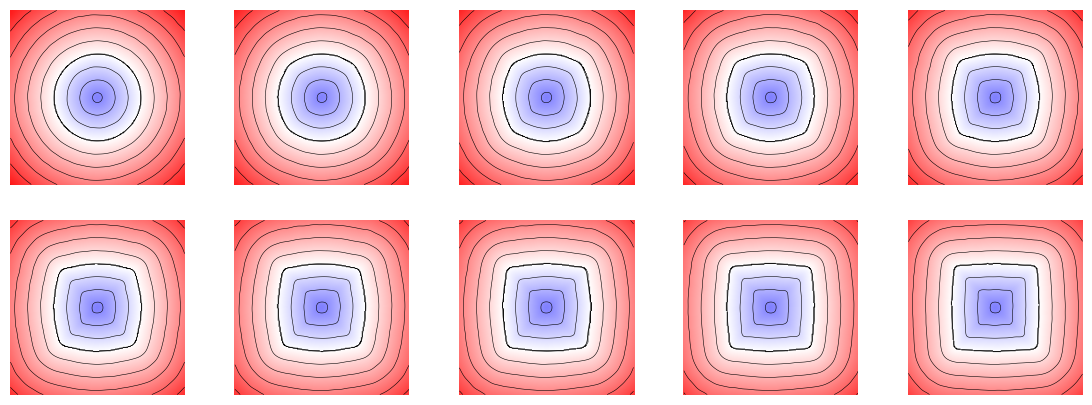

In [27]:
display_multi_slices(net_morph, resolution=200, figsize=(14, 5))

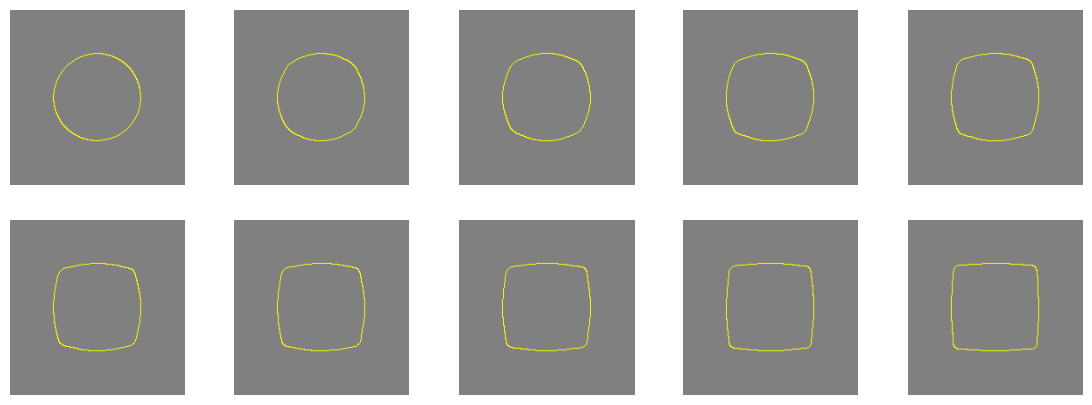

In [28]:
display_multiple_shapes_sdf(net_morph, resolution=200, figsize=(14, 5))

# Bonus: Interpolation of real shapes

Once the method is working (at least partially), try using real shapes. We suggest you to download an image from the following [Website](https://2dshapesstructure.github.io/).
Then you can extract the SDF by first extracting distances <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html">scipy.ndimage.distance_transform_edt</a>, and then find how to compute the <b>signed</b> distance field.


You can also extract the contour using scikit-image <a href="https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours">measure.find_contours</a> and compute the SDF as in previous TD. Good luck!

In [2]:
from scipy.io import loadmat
from scipy.ndimage import distance_transform_edt
import json
from os.path import join
from scipy import spatial

def read_shape(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return torch.Tensor([[pt['x'], pt['y']] for pt in data['points']])

def compute_normals(shape, clockwise=True):
    ld = shape - torch.roll(shape, shifts=-1, dims=0)
    nl = torch.stack((-ld[:,1], ld[:,0]), dim=1) 
    
    rd = torch.roll(shape, shifts=1, dims=0) - shape
    nr = torch.stack((-rd[:,1], rd[:,0]), dim=1)
    
    n = torch.nn.functional.normalize(nl + nr)
    n = 1-n # clockwise
    return n

def compute_sdf(point_cloud, normals, points_query):
    tree = spatial.KDTree(point_cloud)
    dists, idx = tree.query(points_query)
    signs = np.sign(np.einsum('ij,ij->i', points_query-point_cloud[idx], normals[idx])) # (n, 3)
    sdf = signs * dists
    return torch.from_numpy(sdf)

def shape_sample(path, nb_hints, resolution=200):
    pc = read_shape(path)
    pc = 2 * pc - 1

    # Normal
    nc = compute_normals(pc)
    
    # Hint points
    pts_hint = (torch.rand(nb_hints,2, device='cpu') * 2 - 1)
    gt_sdf_hint = compute_sdf(pc, nc, pts_hint)

    # regular points
    coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution)]*2, indexing = 'xy')), dim=2)
    gt_coords = compute_sdf(pc, nc, coords.reshape(-1,2))
    gt_coords = gt_coords.reshape(coords.shape[:2])

    pc = pc.to(device)
    nc = nc.to(device)
    pts_hint = pts_hint.to(device)
    gt_sdf_hint = gt_sdf_hint.to(device)
    coords = coords.to(device)
    gt_coords = gt_coords.to(device)

    return pc, nc, pts_hint, gt_sdf_hint, coords, gt_coords

root = 'dataset-processing/JSON'
pc0,nc0,pts_hints0,gt_sdf_hints0,_,sdf_coords0 = shape_sample(join(root, 'tree-17.json'), 100000)
pc1,nc1,pts_hints1,gt_sdf_hints1,_,sdf_coords1 = shape_sample(join(root, 'apple-17.json'), 100000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07176132820758374..1.0].


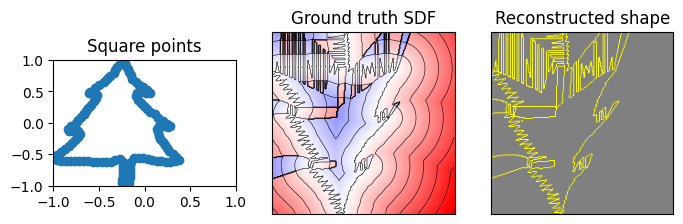

In [3]:
fig, axs =  plt.subplots(1, 3, figsize=(8, 10))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[:, 0], pc_numpy[:, 1])
axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Square points")
sdf_numpy = sdf_coords0.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors='k', linewidths=.4, linestyles='solid')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")
a = 1

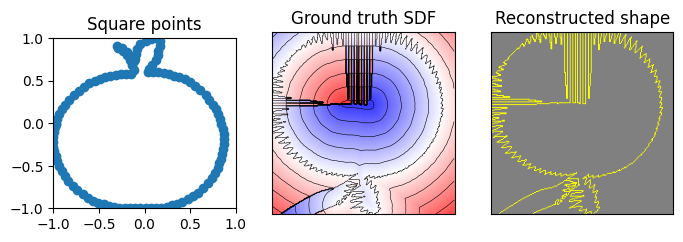

In [4]:
fig, axs =  plt.subplots(1, 3, figsize=(8, 10))
pc_numpy = pc1.detach().cpu().numpy()
axs[0].scatter(pc_numpy[:, 0], pc_numpy[:, 1])
axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Square points")
sdf_numpy = sdf_coords1.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors='k', linewidths=.4, linestyles='solid')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")
a = 1

In [32]:
npl = 128
depth = 3
net_morph = SirenNet(dim_in=3,dim_out=1,num_layers=depth,dim_hidden=npl,skip=[]).to(device)
lpc, leik, lh, llse = [], [], [], []

pc_t0 = torch.concat((pc0,torch.zeros((pc0.size(0),1), device = device)),dim=1)
pc_t1 = torch.concat((pc1,torch.ones((pc1.size(0),1), device = device)),dim=1) # zeros -> ones
pts_hintst0 = torch.concat((pts_hints0,torch.zeros((pts_hints0.size(0),1), device = device)),dim=1)
pts_hintst1 = torch.concat((pts_hints1,torch.ones((pts_hints1.size(0),1), device = device)),dim=1)

optimize_nise_morphing(net_morph, pc_t0, nc0, pts_hintst0, gt_sdf_hints0, pc_t1, nc1, pts_hintst1, gt_sdf_hints1, lpc, leik, lh, llse, nepochs=5000)

torch.save(net, "net_morph_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimizing NN took 113.51 s.


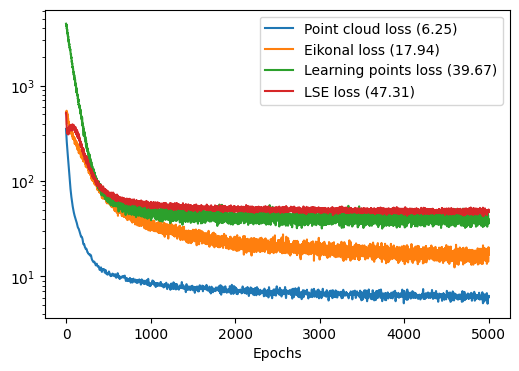

In [33]:
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(lpc, label = 'Point cloud loss ({:.2f})'.format(lpc[-1]))
plt.plot(leik, label = 'Eikonal loss ({:.2f})'.format(leik[-1]))
plt.plot(lh, label = 'Learning points loss ({:.2f})'.format(lh[-1]))
plt.plot(llse, label = 'LSE loss ({:.2f})'.format(llse[-1]))
plt.xlabel("Epochs")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045144081115722656..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01823127269744873..1.0].


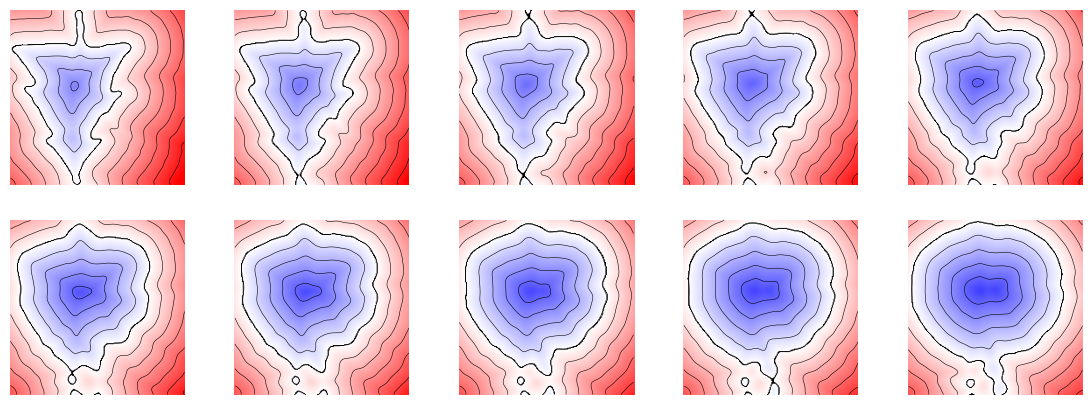

In [34]:
display_multi_slices(net_morph, resolution=200, figsize=(14, 5))

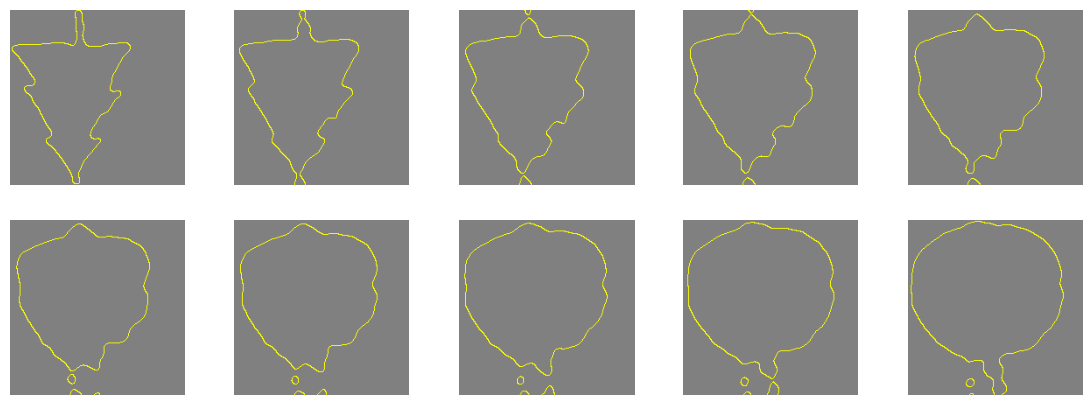

In [35]:
display_multiple_shapes_sdf(net_morph, resolution=200, figsize=(14, 5))